# **Comparing Models**
**Lecture 05**

In [1]:
# [1c]
# Run this cell before continuing.
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(modelr)
library(tidyverse)
library(palmerpenguins)
library(titanic)
library(faraway)

penguins_clean <-
    penguins %>%
    drop_na()

options(repr.plot.width = 10, repr.plot.height = 5) 

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::rec

## 0. Let's get our first model

Let's start with our usual dataset, the penguins dataset. Next week we'll explore a different dataset. 

In [2]:
# [2]
# Fit the model
model_penguins_slr <- lm(body_mass_g ~ flipper_length_mm, data = penguins_clean)
summary(model_penguins_slr)

# Let's also add the fitted values of this model to the dataframe
penguins_pred_slr <- 
    penguins_clean %>%
    add_predictions(model = model_penguins_slr, var = 'pred')


Call:
lm(formula = body_mass_g ~ flipper_length_mm, data = penguins_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1057.33  -259.79   -12.24   242.97  1293.89 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5872.09     310.29  -18.93   <2e-16 ***
flipper_length_mm    50.15       1.54   32.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 393.3 on 331 degrees of freedom
Multiple R-squared:  0.7621,	Adjusted R-squared:  0.7614 
F-statistic:  1060 on 1 and 331 DF,  p-value: < 2.2e-16


Let's plot the model:

`geom_smooth()` using formula = 'y ~ x'


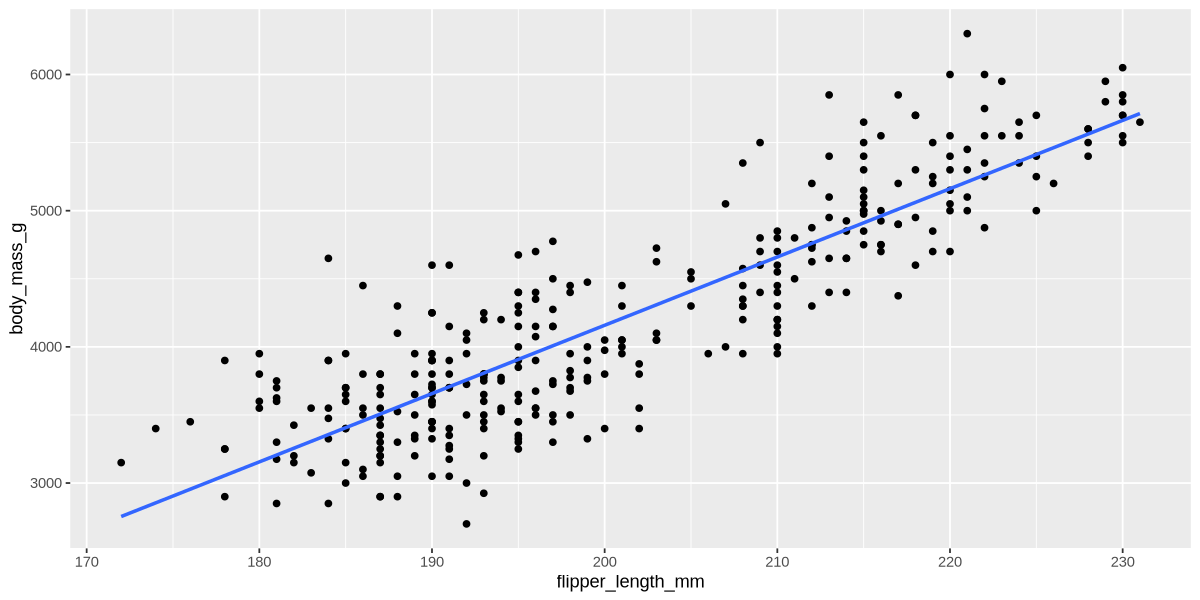

In [3]:
# [3c]
penguins_clean %>%
    ggplot(aes(flipper_length_mm, body_mass_g)) +
    geom_point() + 
    geom_smooth(method = lm, se = FALSE)

## **1. Evaluation metrics**

Many metrics used to evaluate LR measure how far $y$ is from $\hat{y}$:

### **1.1 Basic Quantities**

#### 1.1.1 Residuals Sum of Squares:
$$\text{RSS} = \sum_{i=1}^n(y_i - \hat{y}_i)^2 = \sum_{i=1}^n r_i^2$$ where $r_i$ are the residuals. This is the quantity we minimize in the Least Square method. 

> sum of the squared residuals, small is good

We typically do not use RSS for comparing models, as it will become clearer soon. However, other commonly used measures are derived from RSS (e.g., MSE). Hence, understanding RSS is crucial.

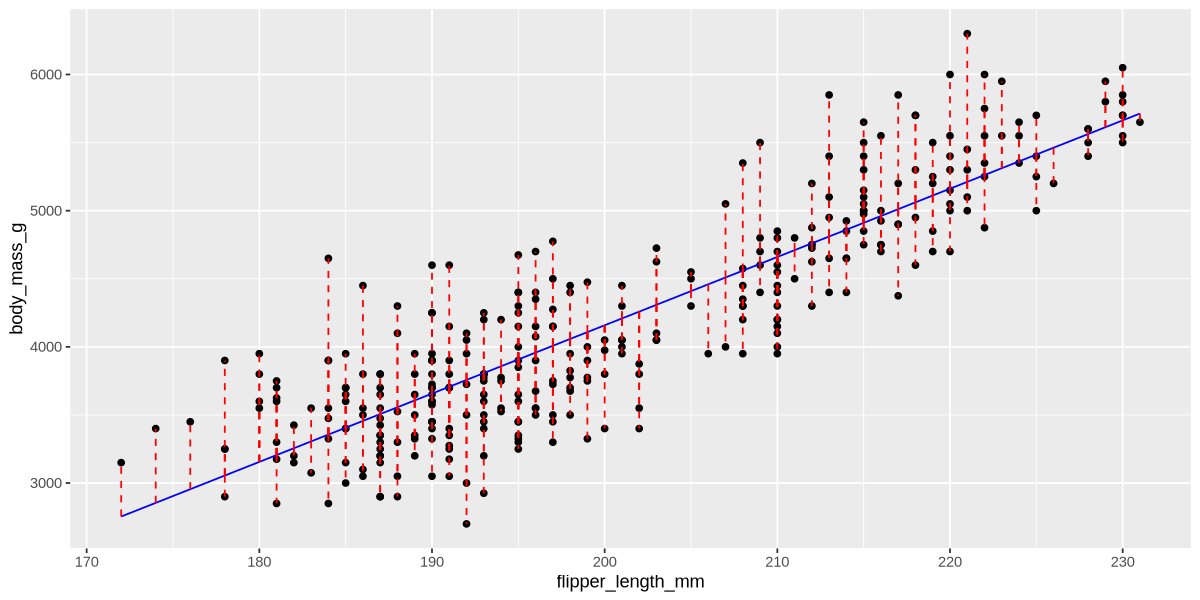

In [4]:
# [4]
# Each dashed red line is one of the residuals. 
# Take the square of it, and sum all of them
penguins_pred_slr %>%
    ggplot(aes(flipper_length_mm, body_mass_g)) +
    geom_point() + 
    geom_line(aes(y = pred), color = 'blue') + 
    geom_segment(aes(x = flipper_length_mm, xend = flipper_length_mm, y = pred, yend = body_mass_g),
                 lty = 2, color = 'red')

Let's do this by hand just so you understand what's going on.

In [5]:
# [5]
# Let's see it in code:
penguins_pred_slr %>%
    mutate(residual = body_mass_g - pred,
           residual_2 = residual ** 2) %>%
    summarise(RSS = sum(residual_2))

RSS
<dbl>
51211963


In [6]:
# [6]
# Or simply:
(RSS <- sum(model_penguins_slr$residuals ** 2))

[1] 51211963

#### 1.1.2 Residuals Standard Error

$$\text{RSE} = \sqrt{\frac{1}{n-p-1} \text{RSS}}$$ where the quantity $p$ is the number of covariate and $n - p - 1$ is the so-called `Degrees of Freedom` 

> gives an idea of the size of the *irreducible* error, very similar to the RSS, small is good

> estimates the standard deviation of the error term $\varepsilon$ (the RSS is divided by the appropriate degrees of freedom to give a "good" estimate of $\sigma = \sqrt{Var(\varepsilon)}$)

> a measure based on *training* data to evaluate the fit of the model (for inference) and needed to estimate the standard errors of $\hat{\beta}_j$ in classical theory!

Again, let's do it by hand:

In [7]:
# [7]
# We already know how to calculate RSS, so:

p <- 1 # This is the number of covariates in the model
degrees_of_freedom <- nrow(penguins_pred_slr) - p - 1
RSE <- sqrt(RSS/degrees_of_freedom) # Residual Standard error

cat("Residual standard error:", RSE, "on", degrees_of_freedom, "degrees of freedom")

Residual standard error: 393.3433 on 331 degrees of freedom

But R gives you this already: 

In [8]:
# [8]
summary(model_penguins_slr)


Call:
lm(formula = body_mass_g ~ flipper_length_mm, data = penguins_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1057.33  -259.79   -12.24   242.97  1293.89 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5872.09     310.29  -18.93   <2e-16 ***
flipper_length_mm    50.15       1.54   32.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 393.3 on 331 degrees of freedom
Multiple R-squared:  0.7621,	Adjusted R-squared:  0.7614 
F-statistic:  1060 on 1 and 331 DF,  p-value: < 2.2e-16


In [9]:
# [9]
summary(model_penguins_slr)$sigma

[1] 393.3433

#### 1.1.3 Mean Squared Error 

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2 = \frac{\text{RSS}}{n}$$
You know this one from DSCI 100, right? Usually computed on both the *training* (MSE) and the *test* sets (MSPE)

> mean of the squared residuals, small is good. 

> *Testing MSE (i.e., DSCI 100's MSPE)*: can be computed on new data $y_{\text{new}}$ and their predicted values (formula above) to evaluate *out-of-sample* prediction performance 

All the three measures listed above, `RSS`, `RSE`, and `MSE`, are *absolute* measures. It is not easy to judge if these are small enough. 

Let's explore some relative measures:

# Part 2 - Goodness of Fit

We know that the best predictor of the response $Y$, in terms of mean squared error, is $E[Y]$, which we can estimate with the sample mean of $Y$. Remember, the mean of $Y$ is the same as the `null model` (i.e., a model with no covariate, only intercept). 

- **Question: So how does a LR help us?**
    - <font color='darkred'>LR allows us to incorporate additional information from covariates $\mathbf{X}$, the best predictor is $E[Y|\mathbf{X}]$.</font> But are we really gaining anything?

## **2. Coefficient of Determination**

### **2.1 Variance decomposition**

**Explained Sum of Squares**: $ESS=\sum_{i=1}^n(\hat{y}_i-\bar{y})^2$

- $\hat{y}_i$ predicts $y_i$ using the LR, while $\bar{y}$ predicts $y_i$ without a model. If our model is better than nothing, this should be large!!

- measures how much variation in the data is *explained* by the additional information given by the LR

**Total Sum of Squares**: $TSS=\sum_{i=1}^n(y_i-\bar{y})^2$

- this is the sum of the squares of the residuals from the null (intercept-only, no explanatory variables) model

- when properly scaled, it is the sample variance of $Y$ which *estimates* the population variance of $Y$

As it turns out, <font color="darkred"> if parameters are estimated using LS and the LR has an intercept</font>, then, 

$$\text{TSS} = \text{ESS} + \text{RSS}$$

or, replacing the formulae

$$\sum_{i=1}^n(y_i-\bar{y})^2 = \sum_{i=1}^n(\hat{y}_i-\bar{y})^2 + \sum_{i=1}^n(y_i - \hat{y}_i)^2$$

### **2.2 Coefficient of Determination: $R^2$**

If our model provides a good fit, we expect the TSS (residuals from the null model, in red) to be much larger than the RSS (residuals from the fitted model, which we minimized by LS, in blue)!! 


![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Coefficient_of_Determination.svg/800px-Coefficient_of_Determination.svg.png)

Using the decomposition above and dividing by TSS: 

$$1=\frac{\text{ESS}}{\text{TSS}} + \frac{\text{RSS}}{\text{TSS}}$$


**The Coefficient of determination**, $R^2$, was first defined as:

$$R^2=1 - \frac{\text{RSS}}{\text{TSS}}$$

*For a LR with an intercept and estimated by LS* it is equivalent to 

$$R^2=\frac{\text{ESS}}{\text{TSS}}$$ 

This seems complicated, but we can code this entire thing in a few lines of code. Let's try! 

In [10]:
# [10]

avg_body_mass <- mean(penguins_pred_slr$body_mass_g)

penguins_pred_slr %>%
    summarise(
        SSR = sum( (pred-body_mass_g) ** 2 ), 
        ESS = sum( (pred - avg_body_mass) ** 2 ), 
        TSS = sum( (body_mass_g - avg_body_mass) ** 2 ), 
        R2 = 1 - SSR/TSS
    )

SSR,ESS,TSS,R2
<dbl>,<dbl>,<dbl>,<dbl>
51211963,164047703,215259666,0.7620922


<font color="blue">**Don't worry; R computes this statistic for you**</font>. I won't ask you to do this calculation by hand. This is for illustration and learning purposes only.


In [11]:
# [11]
summary(model_penguins_slr)


Call:
lm(formula = body_mass_g ~ flipper_length_mm, data = penguins_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1057.33  -259.79   -12.24   242.97  1293.89 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5872.09     310.29  -18.93   <2e-16 ***
flipper_length_mm    50.15       1.54   32.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 393.3 on 331 degrees of freedom
Multiple R-squared:  0.7621,	Adjusted R-squared:  0.7614 
F-statistic:  1060 on 1 and 331 DF,  p-value: < 2.2e-16


In [12]:
# [12]
summary(model_penguins_slr)$r.squared

[1] 0.7620922

#### **2.2.1 About $R^2$**

For a LR with an intercept and estimated by LS, the coefficient of determination:

- the $R^2$ can be used to compare the size of the residuals of the fitted model with those of the null 

- is also interpreted as the proportion of variance of the response (TSS) explained by the model (ESS)

- is between 0 and 1 since we expect TSS to be much larger than RSS (thus their ratio is smaller than 1)



Therefore, for our model 

$$
\text{body_mass}_i = \beta_0 + \beta_1\times \text{flipper_length}_i + \varepsilon_i
$$

the `flipper_length_mm` explains $76.21\%$ of the total variation of `body_mass_g`.

#### **2.2.2 Scope and limitations**

- The $R^2$ is computed based on *in-sample* observations and it does not provide a sense of how good is our model in predicting *out-of-sample* cases (aka test set)!!

- Note that $R^2$ computed as $R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$ ranges between 0 and 1 *if* the LR model has an intercept and is estimated by LS!! 
    - Well, in general we always want a model with intercept anyway; 
    
- The $R^2$ increases as new variables are added to the model, regardless of their relevance! Thus, <font color='darkred'>**it can't be used to compare nested models**</font>.

- The $R^2$  can't be used to *test* any hypothesis to answer this question since its distribution is unknown

### **2.3 Adjusted $R^2$**

The $R^2$ increases as more input variables are added to the model since the $\text{RSS} = \sum_{i = 1}^n(y_i - \hat{y}_i)^2$ decreases as more input variables are included in the model. 

To overcome this issue with $R^2$, we can obtain an **adjusted $R^2$** as follows:

$$ \text{adjusted } R^2 = 1- \frac{\text{RSS}/(n - p - 1)}{\text{TSS}/(n - 1)},$$

where 

- $p$ is the number of regression covariates in the model.
- $n$ is our sample size to estimate the model.

This adjusted coefficient of determination discounts $\text{RSS}$ according to "size" of the model $n - p - 1$. Hence, even if the $\text{RSS}$ decreases, we divide it by $n - p - 1$ to compensate for the model's size.

It is like we are putting a price for the model to grow. 

In [13]:
# [13]

n <- nrow(penguins_pred_slr)

penguins_pred_slr %>%
    summarise(
        SSR = sum( (pred-body_mass_g) ** 2 ), 
        ESS = sum( (pred - avg_body_mass) ** 2 ), 
        TSS = sum( (body_mass_g - avg_body_mass) ** 2 ), 
        R2 = 1 - (SSR/(n - p - 1))/(TSS/(n-1))
    )

SSR,ESS,TSS,R2
<dbl>,<dbl>,<dbl>,<dbl>
51211963,164047703,215259666,0.7613734


In [14]:
# [14]
summary(model_penguins_slr)


Call:
lm(formula = body_mass_g ~ flipper_length_mm, data = penguins_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1057.33  -259.79   -12.24   242.97  1293.89 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5872.09     310.29  -18.93   <2e-16 ***
flipper_length_mm    50.15       1.54   32.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 393.3 on 331 degrees of freedom
Multiple R-squared:  0.7621,	Adjusted R-squared:  0.7614 
F-statistic:  1060 on 1 and 331 DF,  p-value: < 2.2e-16


## **3. F-test: Comparing nested models**

We have learned how to test single coefficients in our regression model using the `t-test`. However, when there are many coefficients, the probability of a false positive grows considerably. 

There's a way we can test multiple coefficients simultaneously.

For example, imagine we have two competing models: 

- Model 1: 
$$
\text{body_mass}_i = \beta_0 + \beta_1\times \text{flipper_length}_i + \beta_2\times \text{bill_depth}_i + \beta_3\times \text{bill_length}_i + \varepsilon_i
$$

- Model 2: 
$$
\text{body_mass}_i = \beta_0 + \beta_1\times \text{flipper_length}_i + \varepsilon_i
$$

Do we have enough evidence that including $\text{bill_depth}$ and $\text{bill_length}$ improves the model?

In other words, we want to test:

$$ 
H_0: \beta_2 = \beta_3 = 0\quad\quad vs\quad\quad H_A: \text{at least one of } \beta_2 \text{ and } \beta_3 \text{ is different from zero}
$$

### **3.1 Nested Models**
In general terms, we have two models: 

- Model 1 (reduced or smaller model): a LR with $q+1$ coefficients $$Y_i=\beta_0 + \beta_1 X_{i1} + \ldots + \beta_q X_{iq} + \varepsilon_i$$

- Model 2 (full model or larger model): LR with $p+1$ coefficients, $k$ additional explanatory variables compared with Model 1
$$Y_i=\underbrace{\beta_0 + \beta_1 X_{i1} +  \ldots + \beta_q X_{iq}}_{\text{Model 1}} + \ldots +  \beta_p X_{ip} + \varepsilon_i$$
    
Is the full model significantly different from a reduced model? 

To answer this question, we need to *simulataneously* test if many parameters (all the additional ones) are zero!.

$$H_0: \beta_{q+1} = \beta_{q+2} = \ldots = \beta_{p} = 0\quad\quad vs \quad\quad H_1: \text{at least one } \beta_j \neq 0 \text{ (for } j = q+1, q+2, \dots, p \text{)}$$

<font color='darkred'>It's crucial for the smaller model to be encapsulated within the larger model. This means we should be able to derive the smaller model from the larger one by setting some coefficients to zero.</font>

### **3.2 The F-statistic**


<font size=4>$$\frac{(RSS_{reduced}-RSS_{full})/k}{RSS_{full}/(n - p - 1)} \sim \mathcal{F}_{k, n-p}$$</font>

- $RSS_{reduced}$ is the **RSS** of the reduced model 


- $RSS_{full}$ is the **RSS** of the full model 


- $k$ is the number of parameters tested (difference between models)


- $p$ is the number of covariates of the full model


<font color="blue">**Don't worry, R computes this statistic for you.**</font>

#### **3.2.1 Comparing nested models in R**

In [15]:
# [15]
# Let's start by fitting the larger model

model_penguins_larger <- lm(body_mass_g ~ flipper_length_mm + bill_depth_mm + bill_length_mm, data = penguins_clean) 
model_penguins_larger


Call:
lm(formula = body_mass_g ~ flipper_length_mm + bill_depth_mm + 
    bill_length_mm, data = penguins_clean)

Coefficients:
      (Intercept)  flipper_length_mm      bill_depth_mm     bill_length_mm  
        -6445.476             50.762             17.836              3.293  


In [16]:
# [16]
# Now we can just call the anova function:
anova(model_penguins_slr, model_penguins_larger)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,331,51211963,NA,NA,NA,NA
2,329,50814912,2,397050.9,1.285349,0.2779392


In [25]:
# [16-2]
(sum(model_penguins_slr$residuals**2) - sum(model_penguins_larger$residuals**2))/(2 * sum(model_penguins_larger$residuals**2) / (n - 3 - 1))

[1] 1.285349

### **3.3 Comparing with the null model**

The fundamental comparison we want to make with any model we develop is against the *null model*. If our model cannot "beat" the *null model*, there's no justification for using the covariates at all. 

- **Question: Is our linear regression better than just using $E[Y]$ to predict?**
    - <font color='darkred'>Statistically, we want to compare our prediction $\hat{Y}$ (the best predictor of $E[Y|\mathbf{X}]$) with $\bar{Y}$ (the best predictor of $E[Y]$).</font>

In [17]:
# [17]
model_null <- lm(body_mass_g ~ 1, data = penguins_clean)
anova(model_null, model_penguins_larger)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,332,215259666,NA,NA,NA,NA
2,329,50814912,3,164444754,354.898,9.260836e-103


The good news is that R does this automatically for us, and provide this test in the summary. 

In [18]:
# [18] 
summary(model_penguins_larger)


Call:
lm(formula = body_mass_g ~ flipper_length_mm + bill_depth_mm + 
    bill_length_mm, data = penguins_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1051.37  -284.50   -20.37   241.03  1283.51 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -6445.476    566.130 -11.385   <2e-16 ***
flipper_length_mm    50.762      2.497  20.327   <2e-16 ***
bill_depth_mm        17.836     13.826   1.290    0.198    
bill_length_mm        3.293      5.366   0.614    0.540    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 393 on 329 degrees of freedom
Multiple R-squared:  0.7639,	Adjusted R-squared:  0.7618 
F-statistic: 354.9 on 3 and 329 DF,  p-value: < 2.2e-16


### **3.4 t-tests vs F-test**

- The test with only one coefficient is just a particular case of the comparison of nested models (the full model has only one additional variable compared to the reduced model). 
    - In this particular case, it can be shown that using classical results the $F$-test (by `anova`) is equivalent to the $t$-test (by `lm`): $F=t^2$ 

<br>
- Both tests ($F$ and $t$) are based on Normality assumptions or approximate Normality distribution given by large sample theory;


# 4. **Variable (Model) Selection**


Some datasets contain *many* variables, but not all of them are relevant. Do we need all the available predictors in the model? You may want to identify the *most relevant* variables to build a model.

But again, what is your goal? Inference or prediction?
    
We need to choose an evaluation metric to decide whether a variable (or set of variables) is relevant. The evaluation metric depends on the goal of the analysis.

## **4.1 Inference**

Do all the predictors help to explain the response, or is only a subset of the predictors useful?

- The $F$-test
     - you can use `anova` to compare a full model (with all terms) vs a reduced model (which excludes terms from $q+1$ to $p$)

- The $t$- tests:
    - In previous lectures, we evaluated the contribution of individual variables to explain a response using $t$-tests calculated by `lm` and given in the `tidy` table (note that $H_0$ contains only *one* coefficient):
$$H_0: \beta_j = 0,  \text{ versus }  H_1: \beta_j \neq 0$$ 


    - The results of the $t$-tests evaluate the contribution of *each* variable (separately) to explain the variation observed in the response ***with all other variables are included*** in the model, in other words, after controlling for other explanatory variables.

    - We can use the results of these tests to establish a *selection rule* to evaluate variables one at a time:
    - for example: discard variables with *p-values* above a threshold
    - <font color='red'>**Warning**</font>: if there are many variables in the model (i.e., $p$ is large) using individual $t$-tests may result in many false discoveries (i.e., reject a true $H_0$, by chance)


Before moving forward, it's important to be aware that the training set is used multiple times to choose variables, which makes it unsuitable for evaluating the final significance of the model. This issue is commonly known as the *"post-inference"* problem.

## **4.2 The $R^2$ (or the RSS) and the adjusted $R^2$**

- You can use the $R^2$ to compare models of equal size (not necessarily nested) 

- You can use the adjusted $R^2$ to compare models of different sizes (not necessarily nested)   


## **4.3 An automated procedure**

When we don't know which variables should be included in the model, ideally, you want to select the best model out of *all possible models* of all possible sizes. 

For example, for a dataset with 2 explanatory variables $X_1$ and $X_2$ there are 4 models to compare: (1) an intercept-only model, (2) a model with only $X_1$, (3) a model with only $X_2$, and (4) a model with both $X_1$ and $X_2$. 

However, the number of *all possible* models quickly becomes too large, even for a small subset of variables. There are a total of $2p$ models from a set of $p$ variables (without considering interaction terms). For $p = 20$ (i.e., 20 available explanatory variables), we need to evaluate more than a million models. 

There are methods to search more efficiently for a good model (although it may not find the "best" one out of all possible):

### **4.3.1 Forward selection**: 

1. Start with the intercept-only model: $Y_i = \beta_0 + \varepsilon_i$
    - remember that $\hat{\beta}_0 = \bar{y}$ from the training samples, so $\hat{y}_{0} = \bar{y}$ for any observation (from the training or the test set)

<br>

2. Select the best model of each size: 
    - **Size 1** Considering one variable at a time, evaluate all models of size 1, and choose the best model of size 1 based on a given measure (RSS, F-statistic, adjusted-$R^2$, call it $\mathcal{M}_1$.   
    - **Size 2** Starting with the best size 1 model, add 1 variable and evaluate all models of size 2. Choose the best model of size 2, call it $\mathcal{M}_2$.
    - $\vdots$ continue until you reach the full model
    - **Size p** there's only one full model, call it $\mathcal{M}_p$.

> Note that we can stop this iteration earlier if we want a model of a predetermined size

3. Now we have to select the best out of $p$ models: $\mathcal{M}_1$ (the best model of size 1), $\mathcal{M}_2$ (the best model of size 2 evaluated), $\ldots, \mathcal{M}_p$ (the full model of size $p$)

> You can't use the RSS to compare models of different sizes

Other selection procedures include:

- **Backward selection**: start with the full model and remove variables, one at a time


- **Hybrid selection**: after adding a variable, the method may also remove variables 

## **4.4 Regularization** 

Some regularization methods, such as Lasso, offer an alternative way to select a model by penalizing the RSS. Lasso is a different estimation method that estimates coefficients to be exactly zero.
They are mainly used when the goal is to predict, but we could also adapt when the purpose is inference. We'll discuss Lasso in the coming lectures.

## **4.5 What is your goal? Inference vs Prediction**

Before we assess or select a model there is a more essential question to answer: 
    
<font color=darkred>**What is your goal?**</font>
    
The evaluation metrics are different depending on the goal of the analysis.
    
> The estimation methodologies can also differ although we cover only LS in the course
   
- **Inference**: your primary goal is to understand the relation between a response variable $Y$ and a set of input variables $X_1, \ldots, X_p$ 
    
    > you estimate the LR using a sample to understand how variables are associated (in the population)
    
    > you use methods to draw conclusions about the population from the results obtained in the sample (inference)
    
- **Prediction**: your primary goal is to make predictions about the response $Y$, and you are not so concerned about how you got those predictions
    
    > you estimate the LR using a sample to make predictions of the response for *new* units (houses, subjects, counties, etc) from the population
  
**Examples of inference problems**: 
    
- A real estate agent wants to identify factors that are related to the assessed values of homes (e.g., size of houses, age, amenities, etc) 
    
    
- Biologists want to verify empirically the central dogma of biology that relates mRNA to protein values 
    
    
**Examples of prediction problems**: 
    

- A real estate agent is interested in determining if a house is under- or over-valued given its characteristics (prediction problem)


- Biologists want to use mRNA data to predict protein values
    
**In this worksheet you will learn different methods to evaluate and select appropriate models based on the goal of your study.**
    
Most of the measures we have seen today are usually used in the context of estimation and inference to build good *generative* models.

In the coming classes, we are going to focus on *prediction*: AIC, BIC, $C_P$, cross-validation

## **5. What have you learned today?**

- We have reviewed different metrics to evaluate a model 
   
   
- Different metrics should be used depending on the goal of the analysis: inference vs prediction


- It is important to understand the set used to compute these metrics: training vs test sets


- Different procedures exist to automate an efficient search of a good model: greedy variable selection


- The $R^2$, coefficient of determination can be used to compare the sum of squares of the residuals of the fitted model with that of the null model


- The $R^2$ is usually interpreted as the part of the variation in the response explained by the model


- Many definitions and interpretations of the $R^2$ are for LS estimators of LR containing an intercept

- The $R^2$ can not be used to compare models of different sizes since bigger models always have larger $R^2$.


- Instead, the $R^2$ can be computed to consider the models' sizes.


- The $R^2$ is not a test; it does not provide a probabilistic result, and its distribution is unknown!


- Instead, we can use an $F$ test, also refer as ANOVA, to compare nested models

    - tests the simultaneous significance of additional coefficients of the full model (not in the reduced model)
    
    - in particular, we can use it to test the significance of the fitted model over the null model
    
    
- These $F$ tests can be used to select variables. Since we are comparing and testing how the fit changes as we select variables